In [29]:
# Contruct a two-layer GNN model
import dgl.nn as dglnn
import torch.nn as nn
import torch.nn.functional as F
import dgl
import torch
import dgl.function as fn

In [2]:
class SAGE(nn.Module):
    def __init__(self, in_feats, hid_feats, out_feats):
        super().__init__()
        self.conv1 = dglnn.SAGEConv(
            in_feats=in_feats, out_feats=hid_feats, aggregator_type='mean')
        self.conv2 = dglnn.SAGEConv(
            in_feats=hid_feats, out_feats=out_feats, aggregator_type='mean')

    def forward(self, graph, inputs):
        # inputs are features of nodes
        h = self.conv1(graph, inputs)
        h = F.relu(h)
        h = self.conv2(graph, h)
        return h

In [3]:
dataset = dgl.data.CiteseerGraphDataset()
graph = dataset[0]

Loading from cache failed, re-processing.


C:\Users\ME\Anaconda3\envs\tf-gpu5\lib\site-packages\dgl\data\citation_graph.py:258: RuntimeWarning: divide by zero encountered in power
  r_inv = np.power(rowsum, -1).flatten()


Finished data loading and preprocessing.
  NumNodes: 3327
  NumEdges: 9228
  NumFeats: 3703
  NumClasses: 6
  NumTrainingSamples: 120
  NumValidationSamples: 500
  NumTestSamples: 1000
Done saving data into cached files.


In [27]:
dir(graph)

['__class__',
 '__contains__',
 '__copy__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__getitem__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__len__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__setstate__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_batch_num_edges',
 '_batch_num_nodes',
 '_canonical_etypes',
 '_dsttypes_invmap',
 '_edge_frames',
 '_etype2canonical',
 '_etypes',
 '_etypes_invmap',
 '_find_etypes',
 '_get_e_repr',
 '_get_n_repr',
 '_graph',
 '_idtype_str',
 '_init',
 '_is_unibipartite',
 '_node_frames',
 '_ntypes',
 '_pop_e_repr',
 '_pop_n_repr',
 '_reset_cached_info',
 '_set_e_repr',
 '_set_n_repr',
 '_srctypes_invmap',
 'add_edge',
 'add_edges',
 'add_nodes',
 'add_self_loop',
 'adj',
 'adjacency_matrix',
 'adjacency_matrix_scipy',
 'all_edges',
 'apply_edges',
 'apply_node

In [29]:
graph.number_of_edges()

9228

In [30]:
graph.number_of_nodes()

3327

In [ ]:
import networkx as nx
import matplotlib.pyplot as plt
# Since the actual graph is undirected, we convert it for visualization
# purpose.
nx_G = graph.to_networkx().to_undirected()
# Kamada-Kawaii layout usually looks pretty for arbitrary graphs
pos = nx.kamada_kawai_layout(nx_G)
f, ax = plt.subplots(figsize=(15,15))
nx.draw(nx_G, pos, ax=ax, with_labels=True, node_color=[[.7, .7, .7]], node_size=20, font_size=8)

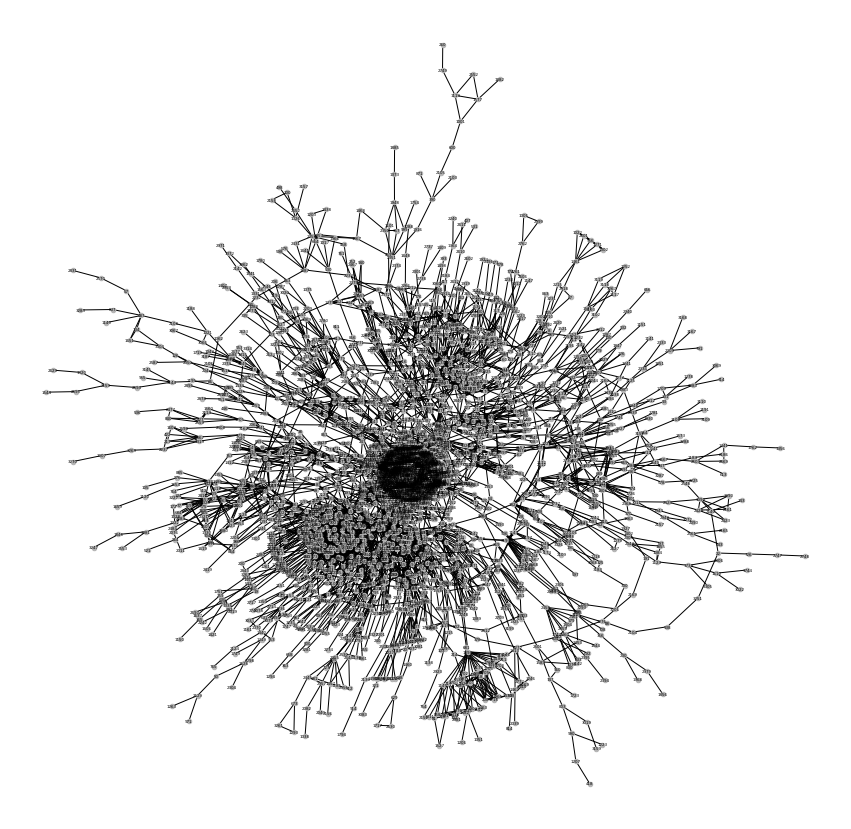

In [12]:
f, ax = plt.subplots(figsize=(15,15))
nx.draw(nx_G, pos, ax=ax, with_labels=True, node_color=[[.7, .7, .7]], node_size=20, font_size=4)

In [4]:
node_features = graph.ndata['feat']
node_labels = graph.ndata['label']
train_mask = graph.ndata['train_mask']
valid_mask = graph.ndata['val_mask']
test_mask = graph.ndata['test_mask']
n_features = node_features.shape[1]
n_labels = int(node_labels.max().item() + 1)

In [5]:
def evaluate(model, graph, features, labels, mask):
    model.eval()
    with torch.no_grad():
        logits = model(graph, features)
        logits = logits[mask]
        labels = labels[mask]
        _, indices = torch.max(logits, dim=1)
        correct = torch.sum(indices == labels)
        return correct.item() * 1.0 / len(labels)

In [6]:
model = SAGE(in_feats=n_features, hid_feats=100, out_feats=n_labels)
opt = torch.optim.Adam(model.parameters())

for epoch in range(100):
    model.train()
    # forward propagation by using all nodes
    logits = model(graph, node_features)
    # compute loss
    loss = F.cross_entropy(logits[train_mask], node_labels[train_mask])
    # compute validation accuracy
    acc = evaluate(model, graph, node_features, node_labels, valid_mask)
    # backward propagation
    opt.zero_grad()
    loss.backward()
    opt.step()
    if epoch%10 == 0:
        print(epoch, acc, loss.item())


0 0.204 1.7944755554199219
10 0.524 1.6334267854690552
20 0.654 1.4198153018951416
30 0.662 1.181162714958191
40 0.67 0.943574845790863
50 0.668 0.7242101430892944
60 0.668 0.5384504795074463
70 0.672 0.3935546875
80 0.668 0.28742220997810364
90 0.664 0.21267780661582947


In [7]:
graph.edata

{}

In [8]:
graph.ndata['feat'].shape

torch.Size([3327, 3703])

In [9]:
graph.ndata['feat']

tensor([[0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        ...,
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.],
        [0., 0., 0.,  ..., 0., 0., 0.]])

In [12]:
import numpy as np
np.max(graph.ndata['feat'].numpy())
np.min(graph.ndata['feat'].numpy())

0.0

Edge Classification

In [26]:
graph.edata['feat'] = torch.randn(graph.number_of_edges(), 10)
graph.edata['label'] = torch.randn(graph.number_of_edges())
graph.edata['train_mask'] = torch.zeros(graph.number_of_edges(), dtype=torch.bool).bernoulli(0.6)

In [13]:
class DotProductPredictor(nn.Module):
    def forward(self, graph, h):
        # h contains the node representations computed from the GNN defined
        # in the node classification section (Section 5.1).
        with graph.local_scope():
            graph.ndata['h'] = h
            graph.apply_edges(fn.u_dot_v('h', 'h', 'score'))
            return graph.edata['score']

In [ ]:
class MLPPredictor(nn.Module):
    def __init__(self, in_features, out_classes):
        super().__init__()
        self.W = nn.Linear(in_features * 2, out_classes)

    def apply_edges(self, edges):
        h_u = edges.src['h']
        h_v = edges.dst['h']
        score = self.W(torch.cat([h_u, h_v], 1))
        return {'score': score}

    def forward(self, graph, h):
        # h contains the node representations computed from the GNN defined
        # in the node classification section (Section 5.1).
        with graph.local_scope():
            graph.ndata['h'] = h
            graph.apply_edges(self.apply_edges)
            return graph.edata['score']

In [24]:
class Model(nn.Module):
    def __init__(self, in_features, hidden_features, out_features):
        super().__init__()
        self.sage = SAGE(in_features, hidden_features, out_features)
        self.pred = DotProductPredictor()
    def forward(self, g, x):
        h = self.sage(g, x)
        return self.pred(g, h)

In [17]:
graph.ndata['feat'].shape[0]

3327

In [21]:
graph.ndata['label'].numpy()

array([3, 1, 5, ..., 3, 1, 5], dtype=int64)

In [22]:
np.max(graph.ndata['label'].numpy())

5

In [23]:
np.min(graph.ndata['label'].numpy())

0

In [31]:
node_features = graph.ndata['feat']
edge_label = graph.edata['label']
train_mask = graph.edata['train_mask']
model = Model(graph.ndata['feat'].shape[1], 2*graph.ndata['feat'].shape[1], 100)
opt = torch.optim.Adam(model.parameters())
for epoch in range(10):
    pred = model(graph, node_features)
    loss = ((pred[train_mask] - edge_label[train_mask]) ** 2).mean()
    opt.zero_grad()
    loss.backward()
    opt.step()
    print(loss.item())

0.9661599397659302
1.7240841388702393
0.9626089334487915
1.0407134294509888
1.3479441404342651
1.1545902490615845
1.0071256160736084
0.9688408970832825
0.962687611579895
0.9624067544937134
